# Introduction to Backtesting

## Initial Setup

Following from our *Introduction to Algorithmic Trading*, let us have a look at how our understanding of technical indicators can be used to:

- Create an algorithmic trading strategy
- Test an algorithmic trading strategy on historical data

Let's start by setting up some of the key functions we need. Many of these are borrowed from the *Introduction to Algorithmic Trading*, so please look there for more information about these:

In [125]:
import PlaygroundData.FixerData as pdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(args):
    fdrh = pdata.FixerDataRequestHandler()
    data = fdrh.get_data(args)

    data["Date"] = pd.to_datetime(data["Date"])
    data.set_index(
    "Date",
    drop=True,
    inplace=True
    )
    return data
    
def sma(data, n, inplace=False):
    sma = data[f"{FROM_CURR}{TO_CURR}"].rolling(window=n, min_periods=1, center=False).mean()
    if inplace == False:
        return np.array(sma)
    else:
        data[f"sma_{n}"] = sma
        return np.array(sma)
    
def ema(data, n, q, inplace=False):
    ema_list = []
    ema = 0
    for x in data[f"{FROM_CURR}{TO_CURR}"]:
        if ema == 0:
            ema = x
        else:
            ema = (q * x) + (1 - q) * (ema)
        ema_list.append(ema)
    if inplace == False:
        return np.array(ema_list)
    else:
        data[f"ema_{n}"] = ema_list
        return np.array(ema_list)
    
def apo(data, n, m, inplace=False):

    short_ema = ema(data, n, 2/(n+1))
    long_ema = ema(data, m, 2/(m+1))
    apo = pd.Series(short_ema) - pd.Series(long_ema)
    if inplace == False:
        return np.array(apo)
    else:
        data[f"apo_{n}_{m}"] = np.array(apo)
        return np.array(apo)
    
def boll_bands(data, n, B, inplace=False):
    
    sma_series = pd.Series(sma(data, n, inplace=False))
    std_dev_series = pd.Series(sma(data, n, inplace=False)).rolling(window=n).std()
    boll_upper = sma_series + (B * std_dev_series)
    boll_lower = sma_series - (B * std_dev_series)
    sma_list, boll_upper, boll_lower = np.array(sma_series), np.array(boll_upper), np.array(boll_lower)
    if inplace == False:
        return sma_list, boll_upper, boll_lower
    else:
        data[f"sma_{n}"] = sma_list
        data["bband_upper"] = boll_upper
        data["bband_lower"] = boll_lower
        return sma_list, boll_upper, boll_lower
    

    

These functions allow us to load in our historical data set, and produce different technical indicators from these which can be used to give us a better understanding of where prices might go. These can be used to help produce an **algorithmic trading strategy**.

## Algorithmic Trading Strategies

An algorithmic trading strategy can be summarised as consisting of two sections:

- Signal Generators
- Execution Logic

**Signal generators** are algorithms which produce a signal to "act" i.e. to buy or to sell. This could be based on rules which we have programmed, or could be discovered through the action of automated systems such as classification algorithms. In this context, these will often be calculated based on the behaviour of **technical indicators**.

Using one or more signal generators, we can decide what we should do in response to them. Should we make a trade? How large should our trades be? Are there some conditions which mean that we should override our signal generators and take some other action? These questions are answered by our **execution logic**, which is used to form the basis of our *quantitative risk management strategy*.

### Signal Generators: A first example

For our first signal, let's start with one which uses two Simple Moving Averages, **SMA(n)** and **SMA(m)**, where **n > m**. When these cross over, we have two possibilities - that the short is now greater than the long, or the long is now greater than the short. 

In the first case, this that we have an indication that the price will *increase*; in the second case, we have an indication that the price will *decrease*. If we use a so-called momentum-following principle, this means that we should buy and sell the asset in each case respectively.

In [126]:
def sma_crossover_signal(data, params, inplace=False):

    # calc SMAs for crossover strategy
    n, m = params[0], params[1]
    short_sma = pd.Series(sma(data, n, inplace=True), index=data.index)
    long_sma = pd.Series(sma(data, m, inplace=True), index=data.index)
    diff = short_sma - long_sma
    # 1 when short is higher than long, otherwise 0
    position = np.where(diff > 0, 1.0, 0.0)
    # first difference gives 1 for buy, -1 for sell, add a 0 at the end so lengths match
    signal = np.append( np.array([0]), np.diff(position, 1))
    if inplace==False:
        return signal, position
    else:
        data[f"sma_{n}"] = short_sma.values
        data[f"sma_{m}"] = long_sma.values
        return signal, position
    
def ema_crossover_signal(data, params, inplace=False):

    # calc SMAs for crossover strategy
    n1, q1, n2, q2 = params[0][0], params[0][1], params[1][0], params[1][1]
    short_ema = pd.Series(ema(data, n1, q1, inplace=True), index=data.index)
    long_ema = pd.Series(ema(data, n2, q2, inplace=True), index=data.index)
    diff = short_ema - long_ema
    # 1 when short is higher than long, otherwise 0
    position = np.where(diff > 0, 1.0, 0.0)
    # first difference gives 1 for buy, -1 for sell, add a 0 at the end so lengths match
    signal = np.append( np.array([0]), np.diff(position, 1))
    if inplace==False:
        return signal, position
    else:
        data[f"ema_{n1}"] = short_ema.values
        data[f"ema_{n2}"] = long_ema.values
        return signal, position
    

Note that the "Position" column is used to track a relative position of the amount of the asset we currently have.

### Backtesting: A first example

Now we can consider how to use this to produce a full algorithmic trading strategy. We first build a data structure containing our signals and relative asset positions using a *signal_builder* function such as the one we have just produced above. After setting up some initial parameters such as our *initial portfolio* - combination of all tradeable assets/cash, we can iterate through our signals and positions and use these to operate on our portfolio.

How much should we buy? How much should we sell? For now, we're going to use very simple rules for this. We will always buy a fixed amount of the asset, and when sell, we will sell all of what we currently have.

This leads to the following logic:

- If the signal is 1, we buy *\\$TRADE_SIZE* in GBP at the current market rate, and add this to our positions. We also deduct this amount from our cash. 
- If the signal is -1, we sell a portion of our GBP at the current market rate for USD, and add the result to our cash.
- If the signal is 0, we just copy the cash and positions from the previous day.

In [127]:
BUY_SIZE = float(500.0)
SELL_RATIO = 1

def backtest(data, signal_builder, signal_builder_params, init_cash):
    
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions[f"signal_{FROM_CURR}{TO_CURR}"], positions[f"position_{FROM_CURR}{TO_CURR}"] = signal_builder(data, signal_builder_params, inplace=False)

    position_list = pd.Series(index=data.index, dtype=float).fillna(0.0)
    cash_list = pd.Series(index=positions.index, dtype=float).fillna(init_cash)

    for i in data.index:
        
        # no trade on first day
        if i == data.first_valid_index():
            continue
        prev_day = i - pd.DateOffset(1)
        # if signal is 1, buy GBP using $TRADE_SIZE
        if positions.loc[i][f"signal_{FROM_CURR}{TO_CURR}"] == 1:
            position_list[i] = position_list[i] + (BUY_SIZE * data.loc[i][f"{FROM_CURR}{TO_CURR}"])
            cash_list[i] = cash_list[prev_day] - (BUY_SIZE * positions.loc[i][f"position_{FROM_CURR}{TO_CURR}"])
        # if signal -1, sell GBP for USD
        elif positions.loc[i][f"signal_{FROM_CURR}{TO_CURR}"] == -1:
            position_list[i] = position_list[prev_day] - (position_list[prev_day] / SELL_RATIO)
            cash_list.loc[i] = cash_list[prev_day] + ((position_list[prev_day] / SELL_RATIO) / data.loc[prev_day][f"{FROM_CURR}{TO_CURR}"])
        # do nothing, position does not change
        else:
            position_list[i] = position_list[prev_day]
            cash_list[i] = cash_list[prev_day]
            
    portfolio[f"Positions_({TO_CURR})"] = position_list
    portfolio[f"Cash_({FROM_CURR})"] = cash_list
    
    return portfolio, positions

The output of this backtesting process will be multiple timeseries:

- The original asset price timeseries
- Indicator timeseries for each of our signal generators
- Our position in the asset (our purchased currency) over time
- Our position in the base currency over time

The following code cells generates these timeseries for an SMA crossover strategy using lags of 8 and 48, and visualises these. 

In [138]:
def plot_backtest(data, portfolio, positions, indicators):
    
    # set-up visualisation env
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(311, ylabel=f"{FROM_CURR}/{TO_CURR}")
    ax2 = fig.add_subplot(312, ylabel=f"Positions ({TO_CURR})")
    ax3 = fig.add_subplot(313, ylabel=f"Cash ({FROM_CURR})")
    ax2.set_ylim([portfolio[f"Positions_({TO_CURR})"].min() * 1.1, portfolio[f"Positions_({TO_CURR})"].max() * 1.1])
    ax3.set_ylim([0, portfolio[f"Cash_({FROM_CURR})"].max() * 1.1])

    # draw time series and signals
    data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='black', lw=1, legend=True)
    buy_index = positions[f"signal_{FROM_CURR}{TO_CURR}"][positions[f"signal_{FROM_CURR}{TO_CURR}"] == 1.0].index
    sell_index = positions[f"signal_{FROM_CURR}{TO_CURR}"][positions[f"signal_{FROM_CURR}{TO_CURR}"] == -1.0].index
    ax1.plot(buy_index, data[f"{FROM_CURR}{TO_CURR}"][buy_index], '^', markersize=8, color='green')
    ax1.plot(sell_index, data[f"{FROM_CURR}{TO_CURR}"][sell_index], 'v', markersize=8, color='red')
    
    for ind in indicators.keys():
        data[ind].plot(ax=ax1, color=indicators[ind]['color'], lw=indicators[ind]['lw'], legend=True)

    # draw positions
    portfolio[f"Positions_({TO_CURR})"].plot(ax=ax2, color='b', lw=1, legend=True)

    # draw cash
    portfolio[f"Cash_({FROM_CURR})"].plot(ax=ax3, color='g', lw=2, legend=True)

    # print useful statistics
    final_pos = portfolio[f'Positions_({TO_CURR})'][-1]
    final_cash = portfolio[f'Cash_({FROM_CURR})'][-1]
    max_cash = portfolio[f'Cash_({FROM_CURR})'].max()
    print(f"Final Position: {final_pos}")
    print(f"Final Cash: {final_cash}")
    print(f"Max Cash: {max_cash}")
    plt.show()

Attempting to fetch data from SQL database.
Final Position: 0.0
Final Cash: 9973.507605203884
Max Cash: 10023.966494814711


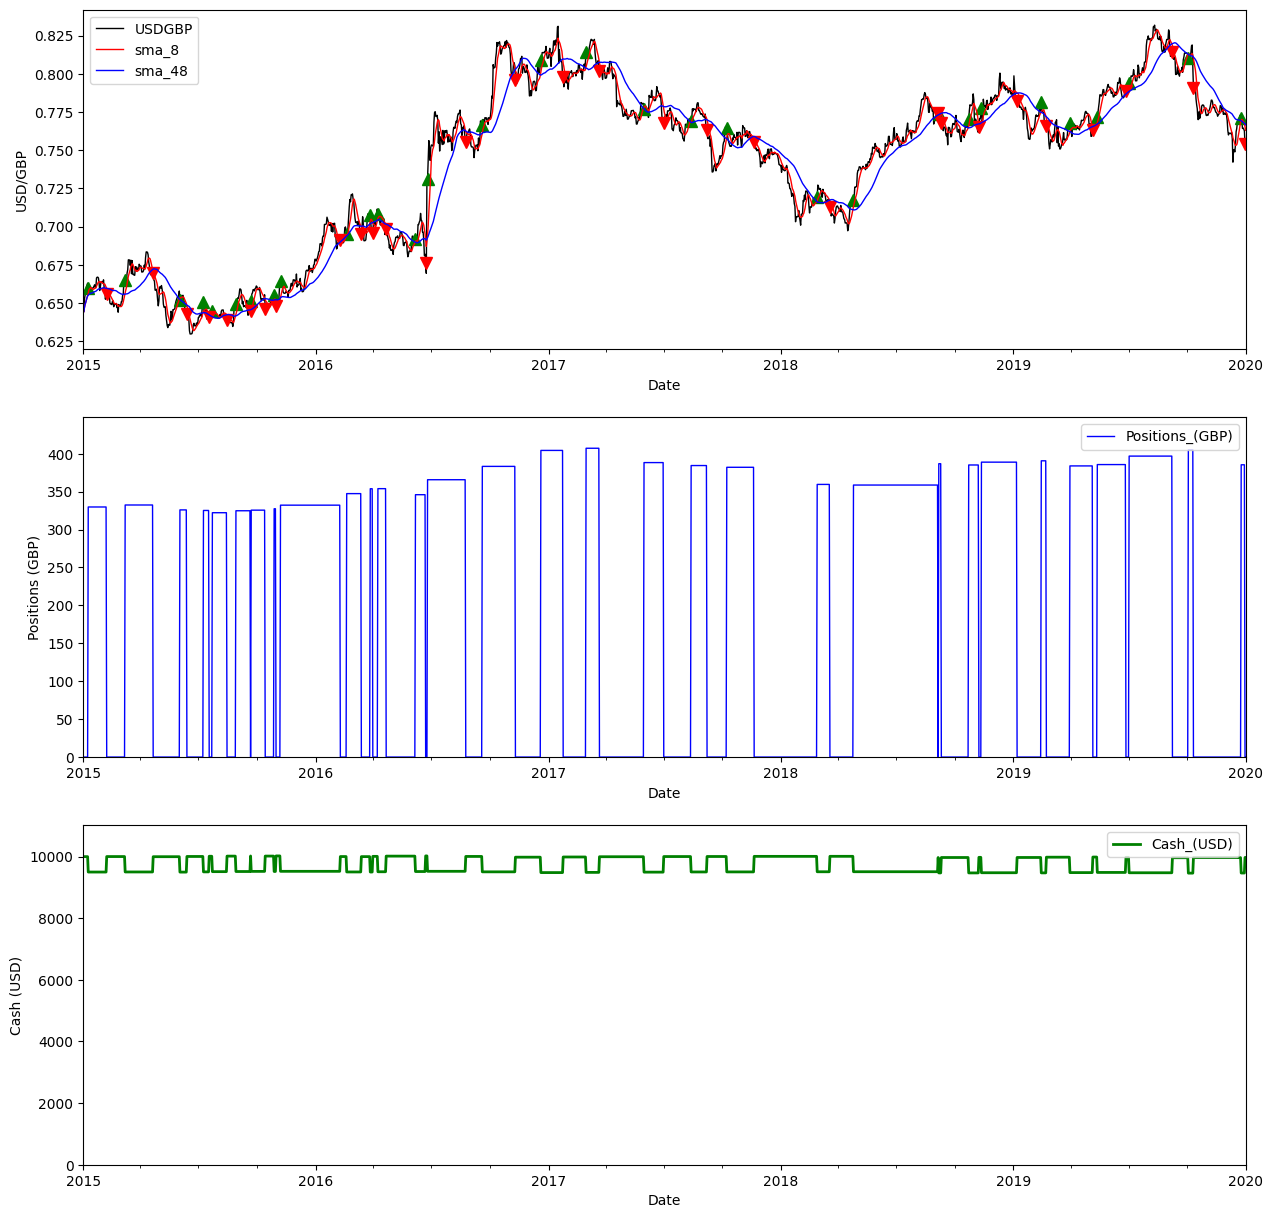

In [139]:
# load data
FROM_CURR = "USD"
TO_CURR = "GBP"
ARGS = {"start_date": "2015-01-01","end_date": "2020-01-01","from_curr": FROM_CURR,"to_curr": TO_CURR}
data = load_data(ARGS)
# generate backtest
n1 = 8
n2 = 48
q = 2/(50+1)
portfolio, positions = backtest(data, sma_crossover_signal, (n1, n2), init_cash=10000)
# plot backtest
plot_backtest(data, 
              portfolio, 
              positions, 
              indicators = { 
                  f"sma_{n1}": {'color': 'r', 'lw': 1},
                  f"sma_{n2}": {'color': 'b', 'lw': 1},
              })

The results are, sadly, not fantastic. Over a 5 year period, we have lost money and our maximum wasn't very high at all. On the bright side, our strategy was *extremely* naive. We didn't adjust the size of our trades at any point, and we use an extremely simple signal generation strategy.